# [MNIST for Experts](https://www.tensorflow.org/versions/master/tutorials/mnist/pros/index.html#deep-mnist-for-experts)


## Setup
### The MNIST Data


In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


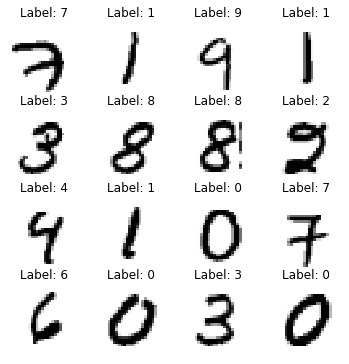

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
figs, axes = plt.subplots(4, 4, figsize=(6, 6))
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(-mnist.train.images[i + 4 * j].reshape(28, 28), cmap='gray', interpolation='none')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_title("Label: {}".format( np.argmax(mnist.train.labels[i + 4 * j]) ))
        axes[i, j].axis('off')

### Start TensorFlow InteractiveSession

Tensorflow relies on a highly efficient C++ backend to do its computation. The connection to this backend is called a session. The common usage for TensorFlow programs is to first create a graph and then launch it in a session.

Here we instead use the convenient InteractiveSession class, which makes TensorFlow more flexible about how you structure your code. It allows you to interleave operations which build a computation graph with ones that run the graph. This is particularly convenient when working in interactive contexts like iPython. If you are not using an InteractiveSession, then you should build the entire computation graph before starting a session and launching the graph.

In [3]:
import tensorflow as tf
sess = tf.InteractiveSession()

### Computation Graph

To do efficient numerical computing in Python, we typically use libraries like NumPy that do expensive operations such as matrix multiplication outside Python, using highly efficient code implemented in another language. Unfortunately, there can still be a lot of overhead from switching back to Python every operation. This overhead is especially bad if you want to run computations on GPUs or in a distributed manner, where there can be a high cost to transferring data.

TensorFlow also does its heavy lifting outside Python, but it takes things a step further to avoid this overhead. Instead of running a single expensive operation independently from Python, TensorFlow lets us describe a graph of interacting operations that run entirely outside Python. This approach is similar to that used in Theano or Torch.

The role of the Python code is therefore to build this external computation graph, and to dictate which parts of the computation graph should be run. See the Computation Graph section of Basic Usage for more detail.


## Build a Softmax Model

### Placeholders

We start building the computation graph by creating nodes for the input images and target output classes.


In [4]:
x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])

Here x and y_ aren't specific values. Rather, they are each a **placeholder** -- a value that we'll input when we ask TensorFlow to run a computation.


### Variables

We now define the weights W and biases b for our model. We could imagine treating these like additional inputs, but TensorFlow has an even better way to handle them: **Variable**. A **Variable** is a value that lives in TensorFlow's computation graph. It can be used and even modified by the computation. In machine learning applications, one generally has the model parameters be **Variables**.

In [5]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

Before * **Variable**s can be used within a session*, they must be initialized using that session. This step takes the initial values (in this case tensors full of zeros) that have already been specified, and assigns them to each Variable. This can be done for all Variables at once.

In [6]:
sess.run(tf.initialize_all_variables())

### Predicted Class and Cost Function

In [7]:
y = tf.nn.softmax(tf.matmul(x,W) + b)
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

Note that tf.reduce_sum sums across all images in the minibatch, as well as all classes. We are computing the cross entropy for the entire minibatch.


## Train the Model

Now that we have defined our model and training cost function, it is straightforward to train using TensorFlow. 


In [8]:
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

What TensorFlow actually did in that single line was to add new operations to the computation graph. These operations included ones to compute gradients, compute parameter update steps, and apply update steps to the parameters.

The returned operation train_step, when run, will apply the gradient descent updates to the parameters. Training the model can therefore be accomplished by repeatedly running train_step.

In [9]:
for i in range(20):
  batch = mnist.train.next_batch(50)
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})

Each training iteration we load 50 training examples. We then run the **train_step** operation, using **feed_dict** to replace the **placeholder** tensors x and y_ with the training examples. Note that you can replace any tensor in your computation graph using feed_dict -- it's not restricted to just placeholders.

## Evaluate the Model


In [10]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
print('accuracy: %.6f'%sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

accuracy: 0.824300


## Build a Multilayer Convolutional Network

### Weight Initialization

In [11]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)


### Convolution and Pooling

TensorFlow also gives us a lot of flexibility in convolution and pooling operations.

In [12]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

### First Convolutional Layer

he convolutional will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of [5, 5, 1, 32].

In [13]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

To apply the layer, we first reshape x to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels.

In [14]:
x_image = tf.reshape(x, [-1,28,28,1])

We then convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool.

In [15]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

### Second Convolutional Layer

The second layer will have 64 features for each 5x5 patch.

In [16]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

### Densely Connected Layer

Now that the image size has been reduced to 7x7, we add a fully-connected layer with 1024 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

In [17]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#### Dropout

To reduce overfitting, we will apply dropout before the readout layer. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.

In [18]:
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Readout Layer
Finally, we add a softmax layer, just like for the one layer softmax above.

In [19]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)


## Train and Evaluate the Model


In [20]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.initialize_all_variables())
for i in range(1000):
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.08
step 100, training accuracy 0.9
step 200, training accuracy 0.74
step 300, training accuracy 0.88
step 400, training accuracy 0.98
step 500, training accuracy 0.94
step 600, training accuracy 0.94
step 700, training accuracy 0.96
step 800, training accuracy 0.96
step 900, training accuracy 0.98
test accuracy 0.9621
